<a href="https://colab.research.google.com/github/nosovdmitry007/removing_the_background_from_a_photo/blob/main/%D0%A3%D0%B4%D0%B0%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%84%D0%BE%D0%BD%D0%B0_%D1%81_%D1%84%D0%BE%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D1%84%D0%B8%D0%B8_(%D1%80%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключение бибилиотек


In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


# Сегментация самолетов


In [ ]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height =  320 # Высота уменьшенной картинки 
directory = '/content/drive/MyDrive/ Базы/Самолеты/База/' # Указываем путь к обучающей выборке с оригинальными изображения
num_classes = 2 # Количество классов на изображении

## Загрузка изображений



In [ ]:
images_airplane = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'Airplane')): # Проходим по всем файлам в каталоге по указанному пути     
    images_airplane.append(image.load_img(os.path.join(directory + 'Airplane',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 39.563332319259644c


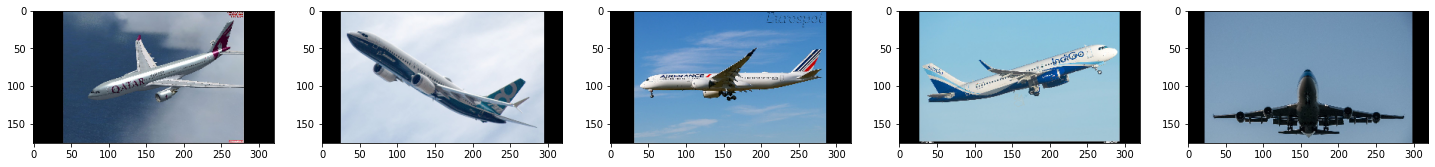

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
    img = random.choice(images_airplane) # Выбираем случайное фото для отображения
    axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [ ]:
segments_airplane = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'Segment')): # Проходим по всем файлам в каталоге по указанному пути     
    segments_airplane.append(image.load_img(os.path.join(directory + 'Segment',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 35.05604314804077c


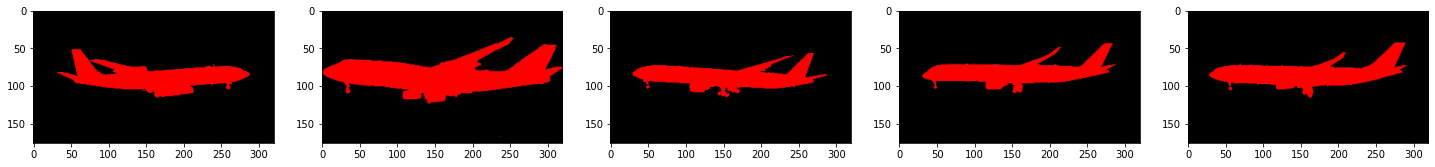

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(segments_airplane) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

## Создание выборки



In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (6 классов)
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 20  : index = 1 # самолет    
    return index  

In [ ]:
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # фон
    elif index == 1:
        color = [255, 0, 0]  # самолет
    return color 

In [ ]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
    y_shape = y.shape # Запоминаем форму массива для решейпа
    y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
    yt = [] # Создаем пустой лист
    for i in range(len(y)): # Проходим по всем трем канала изображения
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
    yt = np.array(yt) # Преобразуем в numpy
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Решейпим к исходныму размеру
    return yt # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
    yTrain = [] # Создаем пустой список под карты сегметации
    for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
        y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
        y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
        yTrain.append(y) # Добавляем очередной элемент в yTrain
        if len(yTrain) % 100 == 0: # Каждые 100 шагов
            print(len(yTrain)) # Выводим количество обработанных изображений
    return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images_airplane: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(1000, 176, 320, 3)


In [ ]:
cur_time = time.time()
yTrain = yt_prep(segments_airplane, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c')

100
200
300
400
500
600
700
800
900
1000
Время обработки:  914.46 c


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [ ]:
y_train.shape

(900, 176, 320, 2)

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

## Обучение модели

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

     #PSPNet 

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)

  #Операции со сверткой и сегментация

    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)

# pooling пирамида

    block_1_out = MaxPooling2D((2,2))(x)
    block_2_out = MaxPooling2D((4,4))(x)
    block_3_out = MaxPooling2D((8,8))(x)
    block_4_out = MaxPooling2D((16,16))(x)

# Сверточные слои

    block_1_out=Conv2D(64,(3,3),padding='same',name='block2_conv1')(block_1_out)
    block_1_out = Activation('relu')(block_1_out)
    block_2_out=Conv2D(64,(3,3),padding='same',name='block2_conv2')(block_2_out)
    block_2_out = Activation('relu')(block_2_out)
    block_3_out=Conv2D(64,(3,3),padding='same',name='block2_conv3')(block_3_out)
    block_3_out = Activation('relu')(block_3_out)
    block_4_out=Conv2D(64,(3,3),padding='same',name='block2_conv4')(block_4_out)
    block_4_out = Activation('relu')(block_4_out)

# Увеличиваем размерность

    block_1_out=Conv2DTranspose(32,(3,3),strides=(2,2),padding='same')(block_1_out)

    block_1_out = Activation('relu')(block_1_out)

    block_2_out=Conv2DTranspose(32,(3,3),strides=(4,4),padding='same')(block_2_out)

    block_2_out = Activation('relu')(block_2_out)

    block_3_out=Conv2DTranspose(32,(3,3),strides=(8,8),padding='same')(block_3_out)

#Операции со сверткой и сегментация

    block_3_out = Activation('relu')(block_3_out)

    block_4_out=Conv2DTranspose(32,(3,3),strides=(16,16),padding='same')(block_4_out)

    block_4_out = Activation('relu')(block_4_out)

#объединяем слои

    out = concatenate([block_1_out, block_2_out, block_3_out])#,block_4_out])
    out=Conv2D(num_classes,(3,3),activation='softmax',padding='same')(out)

# Выходной слой
    model = Model(img_input, out) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [ ]:
modelAir = unet(2, (img_width, img_height,3))
history = modelAir.fit(x_train, y_train, epochs=50, batch_size=16, validation_data = (x_val, y_val)) # Обучаем модель на выборке по трем классам

Epoch 1/50
57/57 [==============================] - 16s 268ms/step - loss: 0.4130 - dice_coef: 0.8546 - val_loss: 0.1228 - val_dice_coef: 0.9288
Epoch 2/50
57/57 [==============================] - 15s 262ms/step - loss: 0.1122 - dice_coef: 0.9355 - val_loss: 0.1038 - val_dice_coef: 0.9374
Epoch 3/50
57/57 [==============================] - 15s 262ms/step - loss: 0.1015 - dice_coef: 0.9437 - val_loss: 0.0882 - val_dice_coef: 0.9496
Epoch 4/50
57/57 [==============================] - 15s 262ms/step - loss: 0.0929 - dice_coef: 0.9480 - val_loss: 0.1012 - val_dice_coef: 0.9461
Epoch 5/50
57/57 [==============================] - 15s 263ms/step - loss: 0.0911 - dice_coef: 0.9493 - val_loss: 0.0828 - val_dice_coef: 0.9596
Epoch 6/50
57/57 [==============================] - 15s 261ms/step - loss: 0.0845 - dice_coef: 0.9527 - val_loss: 0.0866 - val_dice_coef: 0.9551
Epoch 7/50
57/57 [==============================] - 15s 261ms/step - loss: 0.0802 - dice_coef: 0.9553 - val_loss: 0.0780 - val_dic

In [ ]:
 modelAir.save_weights('/content/drive/MyDrive/ Базы/Самолеты/modelAir.h5')

## Распознавание и удаление фона



In [ ]:
modelAir = unet(2, (img_width, img_height,3))
modelAir.load_weights('/content/drive/MyDrive/ Базы/Самолеты/modelAir.h5')

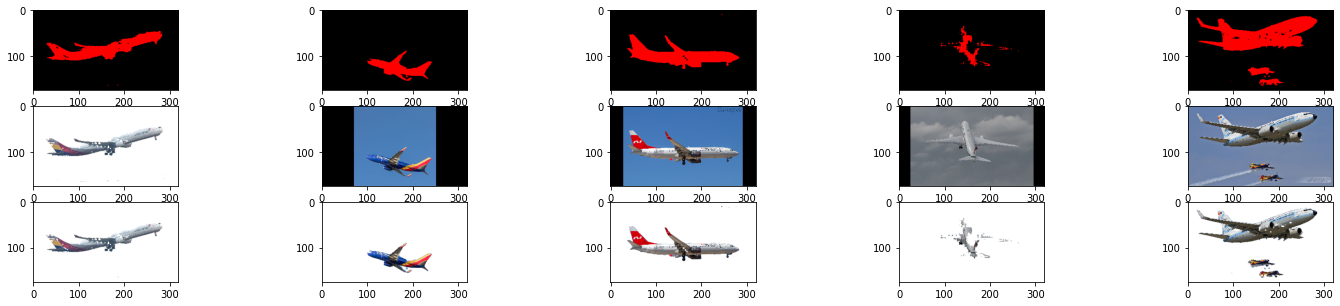

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(3, count, figsize=(25, 5)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(modelAir.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
        pr1.append(index2color(pr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение  
    x_val[idx][pr1[:,:,0] <= 10] = [255, 255, 255]      
    axs[2,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение    
plt.show() 

# Наложение маски

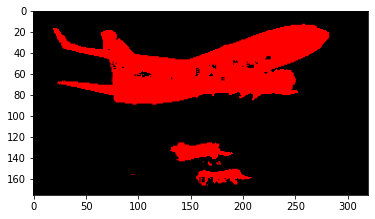

In [ ]:
seg = Image.fromarray(pr1.astype('uint8')).convert('RGBA')
plt.imshow(seg)

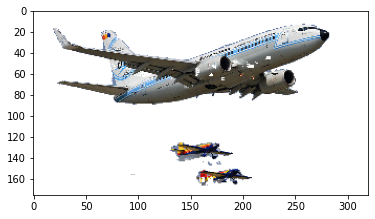

In [ ]:
plt.imshow(Image.fromarray(x_val[idx].astype('uint8')))

In [ ]:
mask = np.array(seg)
mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
mask[mask[:,:,0] > 10] = [0, 150, 0, 150]

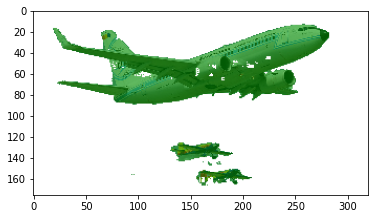

In [ ]:
img2 = Image.fromarray(x_val[idx].astype('uint8'))
img = Image.fromarray(mask).convert('RGBA')
img2.paste(img, (0, 0),img)
plt.imshow(img2)